<a href="https://colab.research.google.com/github/shuai-zhou/demo/blob/main/mapping_using_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [48]:
!pip install mapclassify
!pip install pysal

In [61]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pysal.lib import weights # Calculate spatial weight
from esda.moran import Moran_Local # Calculate local Moran
from splot.esda import lisa_cluster # Plot local Moran
from splot.esda import moran_scatterplot # Plot moran scatterplot
from splot.libpysal import plot_spatial_weights # Plot spatial weight
from splot.esda import plot_local_autocorrelation # Plot local autocorrelation

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Numpy version", np.__version__)
print("Geopandas version", gpd.__version__)
print("Pandas version", pd.__version__)
print("Matplotlib version", matplotlib.__version__)

Numpy version 1.23.5
Geopandas version 0.13.2
Pandas version 1.5.3
Matplotlib version 3.7.1


# Connect Google drive

In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Read shapefile

In [51]:
cus = gpd.read_file('/content/drive/MyDrive/Data/county_cus_2163.zip')

In [52]:
cbe = gpd.read_file('/content/drive/MyDrive/Data/cbe.zip')

In [53]:
cbe.head()

,countyfips,statefips,countyname,area_sqkm,area_sqmi,sup_ton,dem_ton,supdem_rat,fert_dem,nutr_sup,...,LISA_I_S,LISA_CL_S,LISA_P_S,LISA_I_D,LISA_CL_D,LISA_P_D,LISA_I_R,LISA_CL_R,LISA_P_R,geometry
0,28107,28,Panola,1826.659768,705.273336,1277.544800,24139.109375,0.052924,2.189866e+07,1.158970e+06,...,0.238455,2.0,0.002,0.068486,0.0,0.168,0.028214,2.0,0.011,"POLYGON ((908509.437 -1143420.352, 908507.330 ..."
1,28101,28,Newton,1502.106523,579.963329,5373.788574,7646.332520,0.702793,6.936645e+06,4.875025e+06,...,0.415929,1.0,0.039,0.225420,2.0,0.006,0.112281,0.0,0.058,"POLYGON ((1020705.790 -1313774.589, 1020734.62..."
2,28027,28,Coahoma,1510.714082,583.286707,115.948730,31967.982422,0.003627,2.900090e+07,1.051870e+05,...,0.485069,2.0,0.001,0.012758,0.0,0.492,0.041051,2.0,0.001,"POLYGON ((869376.350 -1174565.716, 868998.537 ..."
3,22065,22,Madison,1686.895896,651.310506,239.688400,28905.736328,0.008292,2.622287e+07,2.174419e+05,...,0.298347,0.0,0.067,0.032055,0.0,0.348,0.035142,2.0,0.008,"MULTIPOLYGON (((847735.536 -1384799.637, 84763..."
4,51540,51,Charlottesville,26.554047,10.252518,0.000000,11.323624,0.000000,1.027263e+04,0.000000e+00,...,0.159810,0.0,0.446,0.225523,0.0,0.412,0.018006,0.0,0.341,"POLYGON ((1862792.354 -529689.808, 1862843.438..."


In [54]:
cbe.describe().T

,count,mean,std,min,25%,50%,75%,max
area_sqkm,3109.0,2.597242e+03,3.436473e+03,5.172648,1.150241e+03,1.669249e+03,2.518354e+03,5.207757e+04
area_sqmi,3109.0,1.002795e+03,1.326822e+03,1.997159,4.441079e+02,6.444972e+02,9.723366e+02,2.010715e+04
sup_ton,3109.0,2.878371e+03,3.915102e+03,0.000000,8.062095e+02,1.829831e+03,3.729057e+03,7.682104e+04
dem_ton,3109.0,3.870699e+04,6.606078e+04,0.000000,6.197265e+03,1.828226e+04,4.560223e+04,1.152009e+06
supdem_rat,3109.0,2.644486e-01,1.280855e+00,0.000000,4.800452e-02,1.053203e-01,2.072424e-01,4.493883e+01
fert_dem,3109.0,3.511444e+07,5.992940e+07,0.000000,5.622070e+06,1.658541e+07,4.136970e+07,1.045086e+09
nutr_sup,3109.0,2.611217e+06,3.551725e+06,0.000000,7.313818e+05,1.659997e+06,3.382948e+06,6.969096e+07
nutr_septi,3109.0,1.125063e+05,2.033845e+05,89.012894,1.941290e+04,5.220606e+04,1.218101e+05,4.267367e+06
totaln,3109.0,1.940687e+06,2.772670e+06,0.000000,4.524355e+05,1.191739e+06,2.539174e+06,5.783998e+07
totalp,3109.0,5.581127e+05,7.844444e+05,0.000000,1.227581e+05,3.396728e+05,7.212458e+05,1.231893e+07


In [55]:
cbe.isnull().sum()

countyfips    0
statefips     0
countyname    0
area_sqkm     0
area_sqmi     0
sup_ton       0
dem_ton       0
supdem_rat    0
fert_dem      0
nutr_sup      0
nutr_septi    0
totaln        0
totalp        0
totalnp       0
supdem_cat    0
LISA_I_S      0
LISA_CL_S     0
LISA_P_S      0
LISA_I_D      0
LISA_CL_D     0
LISA_P_D      0
LISA_I_R      0
LISA_CL_R     0
LISA_P_R      0
geometry      0
dtype: int64

# Mapping

## Choropleth

<Axes: >

<Axes: >

(-2265298.642771698, 2749841.931116095, -2259467.945392229, 874850.9862731698)

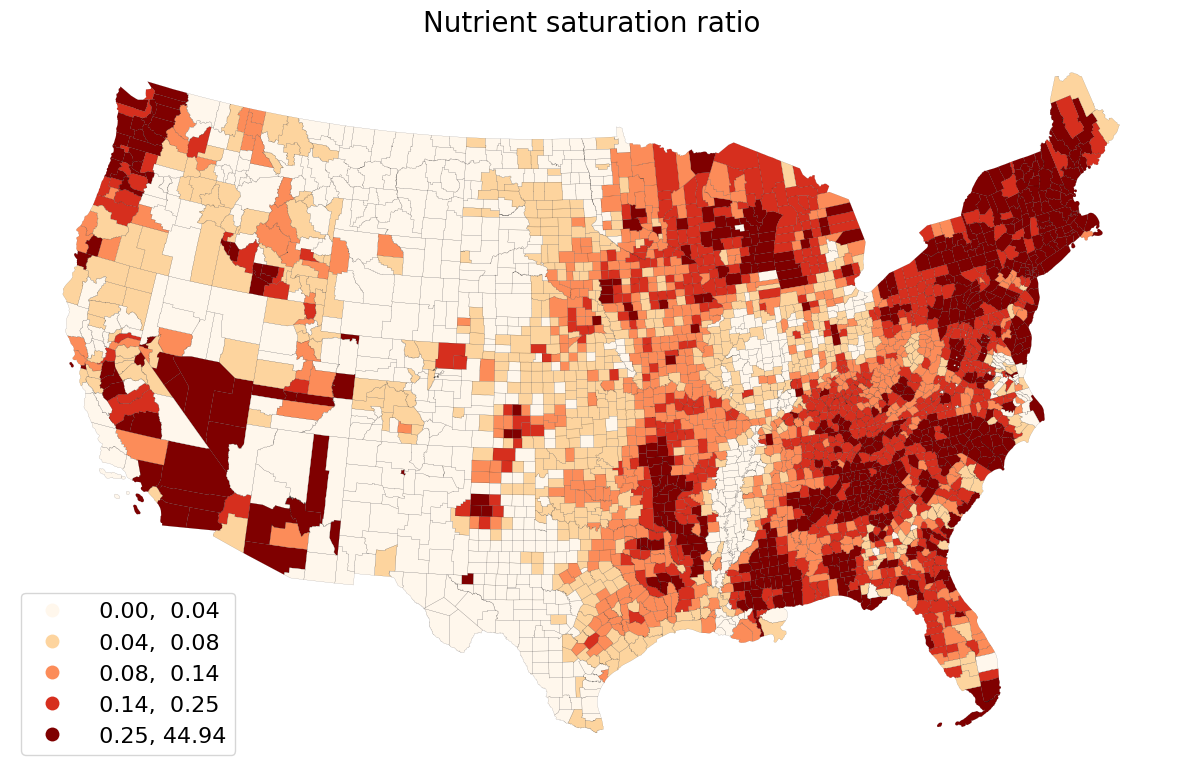

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
cbe.plot(ax=ax, column='supdem_rat', scheme='quantiles', cmap='OrRd', legend=True,
         legend_kwds={'loc':'lower left', 'fontsize':16})
cus.boundary.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.1, alpha=0.6)

ax.axis('off')
ax.title.set_size(20)
ax.title.set_text('Nutrient saturation ratio')
fig.savefig('/content/drive/MyDrive/Data/nutr_saturation_ratio.png', bbox_inches='tight', dpi=800)

# Local Indicator of Spatial Autocorrelation (LISA) map

## Generate spatial weight

In [57]:
w = weights.contiguity.Queen.from_dataframe(cbe)
w.transform = 'r'

<ipython-input-57-7a0f5bfcf436>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.contiguity.Queen.from_dataframe(cbe)


(<Figure size 1500x1000 with 1 Axes>, <Axes: >)

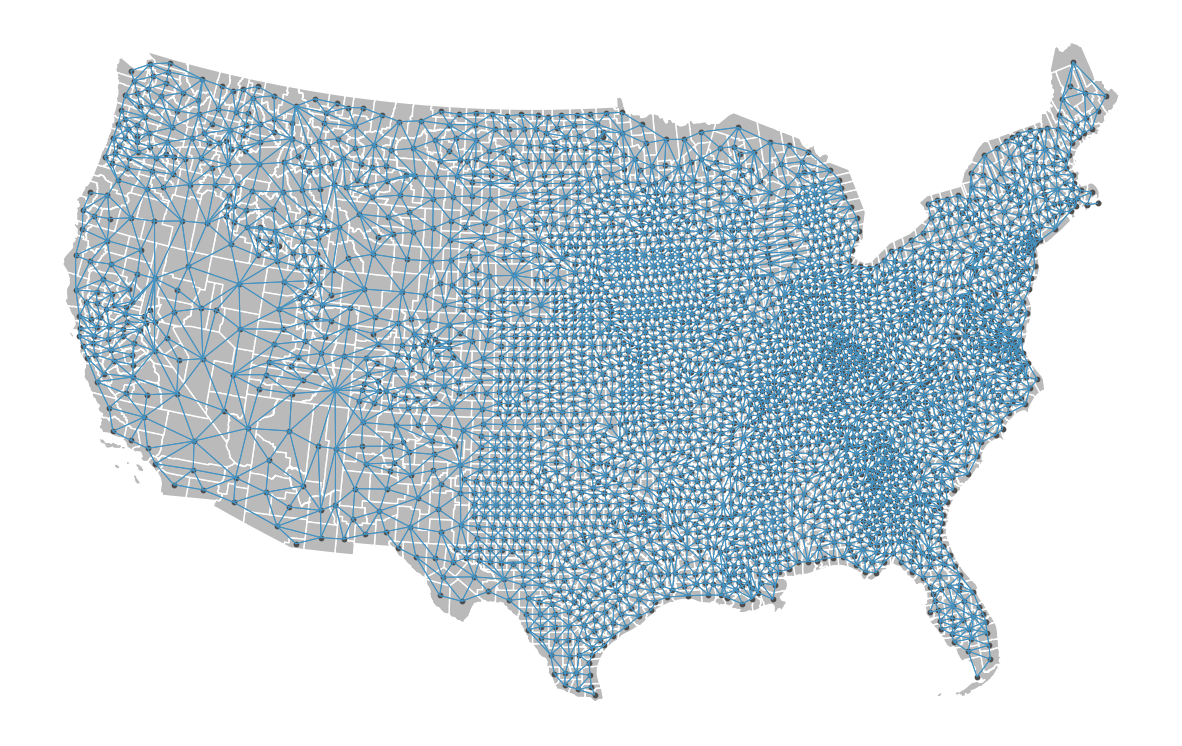

In [58]:
plot_spatial_weights(w, cbe, figsize=(15, 10))

## Calculate LISA

In [59]:
lisa = Moran_Local(cbe['supdem_rat'], w)

## Plot lisa

<Axes: >

(<Figure size 1500x1000 with 1 Axes>, <Axes: >)

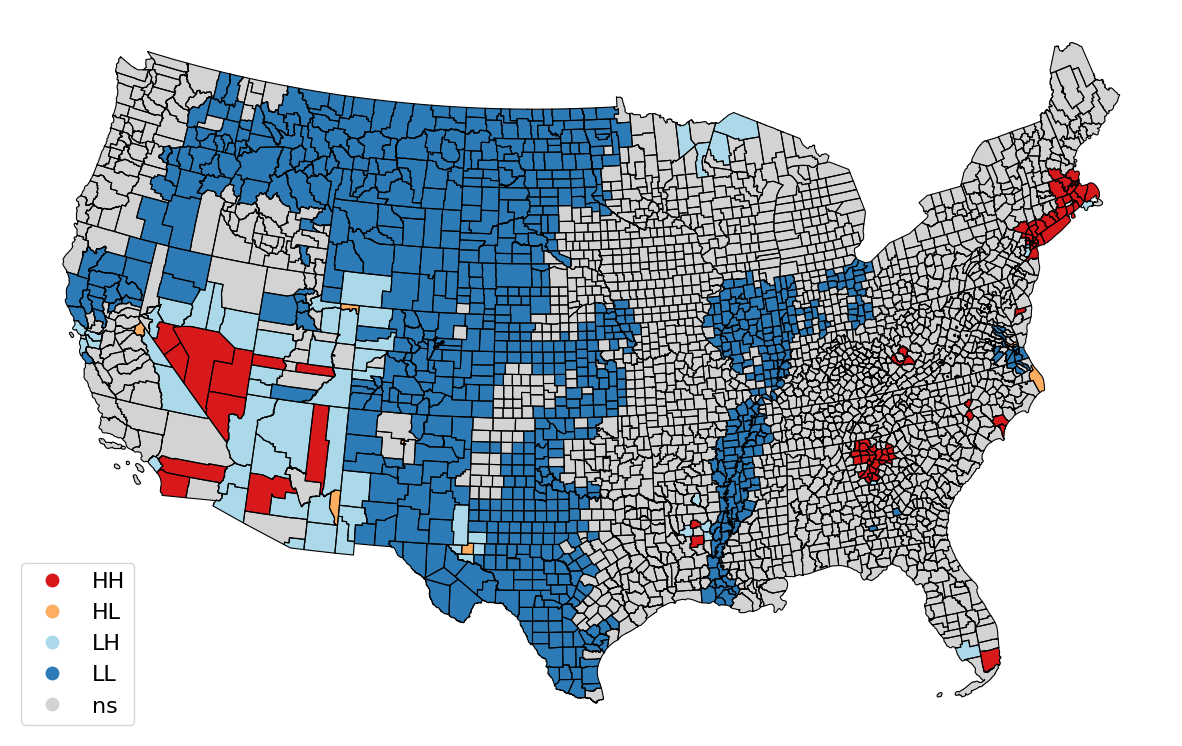

In [64]:
fig, ax = plt.subplots(figsize=(15, 10))
cus.boundary.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8)
lisa_cluster(lisa, cbe, p=0.05, ax=ax, legend=True, legend_kwds={'loc':'lower left', 'fontsize':16})
# leg = [Line2D([0],[0], color='#d7191c', lw=20,),
#        Line2D([0],[0], color='#fdae61', lw=20),
#        Line2D([0],[0], color='#abd9e9', lw=20),
#        Line2D([0],[0], color='#2c7bb6', lw=20),
#        Line2D([0],[0], color='lightgrey', lw=20)]
# fig.legend(leg, ['High-High','High-Low','Low-High','Low-Low','Non-significant'],
#            loc='lower left', fontsize=20, frameon=False, ncol=1, bbox_to_anchor=(0.12, 0.12))
fig.savefig('/content/drive/MyDrive/Data/lisa_map.png', bbox_inches='tight', dpi=600)